In [1]:
import os
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf
from sklearn.utils import shuffle
import math
from scipy import stats


In [85]:
data = pd.read_csv('/Users/_fangkhai/Documents/Computer Science Semester 5/Introduction to Data Science/Assignment Dataset/INFY Historical Data (2009-2019).csv').fillna(0)
data.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

In [86]:
data["Date"] = pd.to_datetime(data["Date"])

In [87]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-12-31,731.15,729.70,737.75,725.45,6.93M,-0.24%
1,2019-12-30,732.90,736.10,737.95,727.25,5.37M,-0.55%
2,2019-12-27,736.95,729.75,737.50,728.85,3.40M,1.10%
3,2019-12-26,728.95,732.00,734.55,726.55,3.82M,-0.61%
4,2019-12-24,733.40,736.95,736.95,728.30,2.89M,-0.35%


In [88]:
data.set_index("Date")

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-12-31,731.15,729.70,737.75,725.45,6.93M,-0.24%
2019-12-30,732.90,736.10,737.95,727.25,5.37M,-0.55%
2019-12-27,736.95,729.75,737.50,728.85,3.40M,1.10%
2019-12-26,728.95,732.00,734.55,726.55,3.82M,-0.61%
2019-12-24,733.40,736.95,736.95,728.30,2.89M,-0.35%
...,...,...,...,...,...,...
2009-01-07,147.28,145.25,148.52,142.08,22.54M,1.63%
2009-01-06,144.92,146.34,147.58,142.05,11.56M,-0.36%
2009-01-05,145.45,141.38,146.93,141.35,11.24M,3.60%


In [89]:
data = data[data["Date"].between('2018-12-31', '2019-12-31')]

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 0 to 245
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      246 non-null    datetime64[ns]
 1   Price     246 non-null    float64       
 2   Open      246 non-null    float64       
 3   High      246 non-null    float64       
 4   Low       246 non-null    float64       
 5   Vol.      246 non-null    object        
 6   Change %  246 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 15.4+ KB


In [91]:
data["Vol."] = data["Vol."].str.replace("M", "")
data["Change %"] = data["Change %"].str.replace("%", "")

In [92]:
data['Vol.'] = pd.to_numeric(data['Vol.'], errors='coerce')
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

<AxesSubplot:>

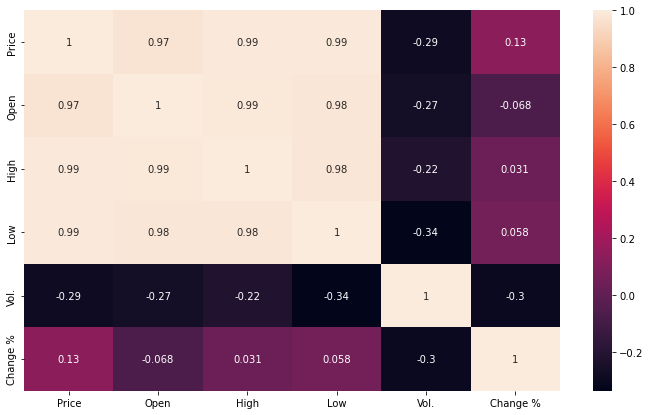

In [93]:
corr = data.corr()
plt.figure(figsize = (12, 7))
sns.heatmap(corr, annot = True)

In [94]:
data.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        1
Change %    0
dtype: int64

In [95]:
data.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.               float64
Change %           float64
dtype: object

In [96]:
data = data.fillna(data["Vol."].mean())

In [97]:
data.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [99]:
data.set_index("Date", inplace = True)

In [100]:
z = np.abs(stats.zscore(data))
z

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-12-31,0.242272,0.274449,0.251792,0.200437,0.272258,0.172318
2019-12-30,0.198855,0.113491,0.246812,0.155583,0.470496,0.350840
2019-12-27,0.098377,0.273192,0.258017,0.115713,0.720835,0.599356
2019-12-26,0.296853,0.216605,0.331467,0.173026,0.667464,0.385392
2019-12-24,0.186450,0.092114,0.271711,0.129418,0.785644,0.235665
...,...,...,...,...,...,...
2019-01-04,1.981418,1.731872,1.841563,2.055637,0.150266,0.730918
2019-01-03,1.780461,1.725585,1.764377,1.754120,0.284966,0.028349
2019-01-02,1.782942,1.876483,1.839073,1.780285,0.209991,0.311418


In [101]:
(np.abs(stats.zscore(data)) > 3).sum()

Price       0
Open        0
High        0
Low         0
Vol.        2
Change %    2
dtype: int64

In [102]:
data_clean = data[((np.abs(stats.zscore(data)))<3).all(axis=1)]
data_clean

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-12-31,731.15,729.70,737.75,725.45,6.93,-0.24
2019-12-30,732.90,736.10,737.95,727.25,5.37,-0.55
2019-12-27,736.95,729.75,737.50,728.85,3.40,1.10
2019-12-26,728.95,732.00,734.55,726.55,3.82,-0.61
2019-12-24,733.40,736.95,736.95,728.30,2.89,-0.35
...,...,...,...,...,...,...
2019-01-04,661.05,671.75,673.90,651.00,7.89,-1.21
2019-01-03,669.15,672.00,677.00,663.10,6.83,0.01
2019-01-02,669.05,666.00,674.00,662.05,7.42,0.60


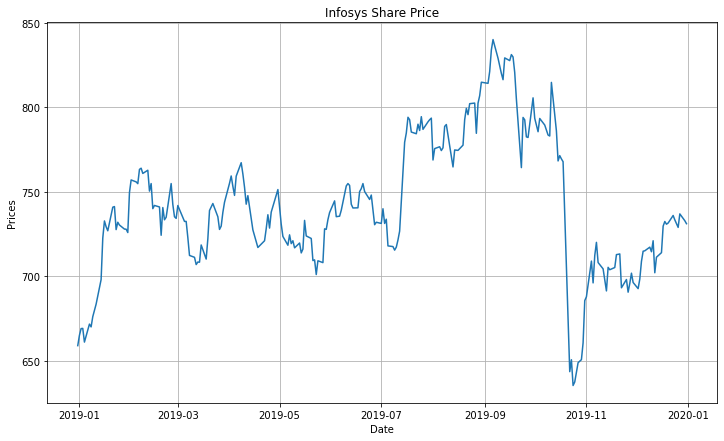

In [103]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.plot(data["Price"])
plt.title("Infosys Share Price")
plt.show()

<AxesSubplot:ylabel='Density'>

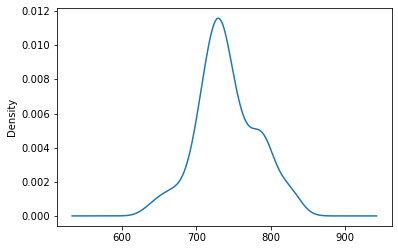

In [104]:
df = data["Price"]
df.plot(kind = "kde")

### SelectKBest

In [105]:
open_price_crosstab = pd.crosstab(data["Open"], data["Price"], margins = True)
open_price_crosstab

Price,635.35,637.45,643.55,648.85,650.6,650.65,658.95,660.6,661.05,665.05,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
Open,,,,,,,,,,,,,,,,,,,,,
630.0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
647.0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
648.85,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
650.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
651.0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
832.05,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
836.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [106]:
high_price_crosstab = pd.crosstab(data["High"], data["Price"], margins = True)
high_price_crosstab

Price,635.35,637.45,643.55,648.85,650.6,650.65,658.95,660.6,661.05,665.05,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
High,,,,,,,,,,,,,,,,,,,,,
648.85,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
652.5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
653.2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
653.75,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
656.65,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
837.95,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
840.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [107]:
low_price_crosstab = pd.crosstab(data["Low"], data["Price"], margins = True)
low_price_crosstab

Price,635.35,637.45,643.55,648.85,650.6,650.65,658.95,660.6,661.05,665.05,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
Low,,,,,,,,,,,,,,,,,,,,,
615.1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
632.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
636.0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
638.35,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
647.0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
826.65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
827.55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [108]:
vol_price_crosstab = pd.crosstab(data["Vol."], data["Price"], margins = True)
vol_price_crosstab

Price,635.35,637.45,643.55,648.85,650.6,650.65,658.95,660.6,661.05,665.05,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
Vol.,,,,,,,,,,,,,,,,,,,,,
2.89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2.94,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3.09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3.22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31.06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
31.57,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
60.52,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [109]:
change_price_crosstab = pd.crosstab(data["Change %"], data["Price"], margins = True)
change_price_crosstab

Price,635.35,637.45,643.55,648.85,650.6,650.65,658.95,660.6,661.05,665.05,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
Change %,,,,,,,,,,,,,,,,,,,,,
-16.19,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-5.05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-3.52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-3.18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-3.12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3.89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4.05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [126]:
shuffled_data = shuffle(data, random_state = 30)

#X = Independent Variable
target_col = "Price"
X = data.drop("Price", axis = 1)

#y = Dependent Variable
y = shuffled_data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(196, 5) (50, 5) (196,) (50,)


In [127]:
X_n = SelectKBest(f_classif, k = 1).fit_transform(X, y)
X_n.shape

#Another method (Giving Same Results)

X_new = SelectKBest(f_classif, k = 1).fit(X_train, y_train)
X_train.columns[X_new.get_support()]

Index(['High'], dtype='object')

In [128]:
pd.crosstab(np.squeeze(X_n), np.squeeze(y))

Price,635.35,637.45,643.55,648.85,650.60,650.65,658.95,660.60,661.05,665.05,...,820.10,820.70,821.30,827.70,829.10,829.30,829.85,831.25,834.05,840.15
row_0,,,,,,,,,,,,,,,,,,,,,
648.85,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
652.50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
653.20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
653.75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
656.65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
837.50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
837.95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


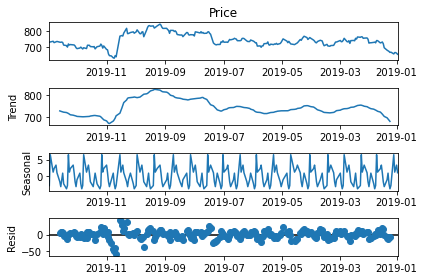

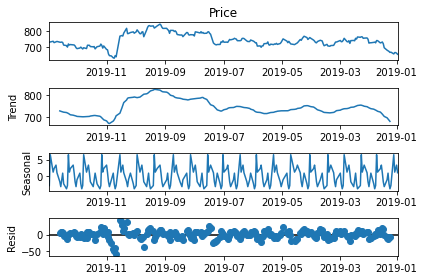

In [129]:
seasonal_decompose(data["Price"], model = "additive", period = 12).plot()

In [130]:
data = data.groupby("Date").sum()

In [131]:
data = data.resample(rule = 'MS').sum()

In [132]:
data.head(10)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-12-01,658.95,660.00,662.00,655.80,3.37,0.30
2019-01-01,16258.61,16224.96,16388.68,16049.88,212.49,13.08
2019-02-01,14947.55,14951.40,15088.70,14803.65,119.02,-1.92
2019-03-01,13784.60,13815.50,13911.90,13680.05,162.37,1.42
2019-04-01,14118.25,14100.90,14218.70,13972.95,171.64,1.14
2019-05-01,15848.25,15846.90,16010.45,15705.15,195.62,-1.67
2019-06-01,14143.00,14120.20,14244.40,14029.75,124.70,-0.71
2019-07-01,17509.50,17474.80,17653.70,17340.90,177.79,8.41
2019-08-01,15743.70,15725.70,15884.95,15584.30,150.03,2.85


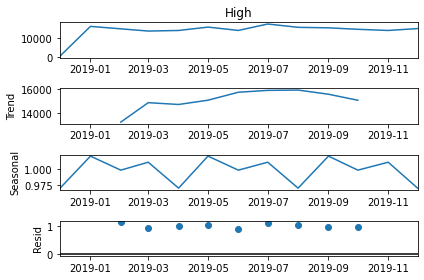

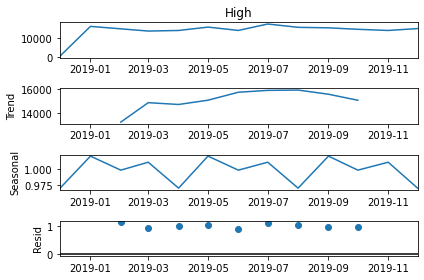

In [135]:
result = seasonal_decompose(data["High"], model = "multiplicable", period = 4)
result.plot()

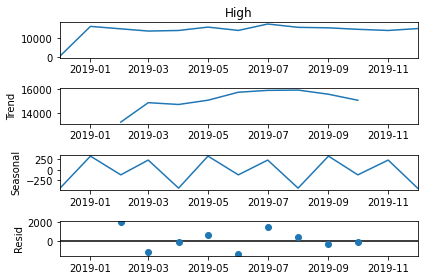

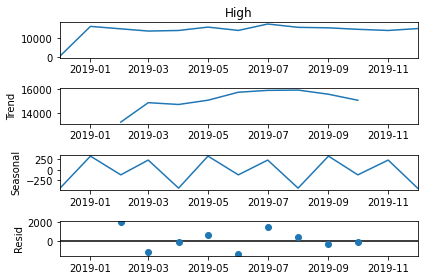

In [136]:
result = seasonal_decompose(data["High"], model = "additive", period = 4)
result.plot()

In [153]:
train_size = int(len(data) * 0.7)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [169]:
model = ExponentialSmoothing(train["High"], trend = "add", seasonal = "add", seasonal_periods = 4).fit()

/Users/_fangkhai/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [176]:
test_pred = model.forecast(4)

In [177]:
test_pred

2019-09-01    20315.666540
2019-10-01    18612.431728
2019-11-01    21703.136842
2019-12-01    21519.696864
Freq: MS, dtype: float64

<AxesSubplot:xlabel='Date'>

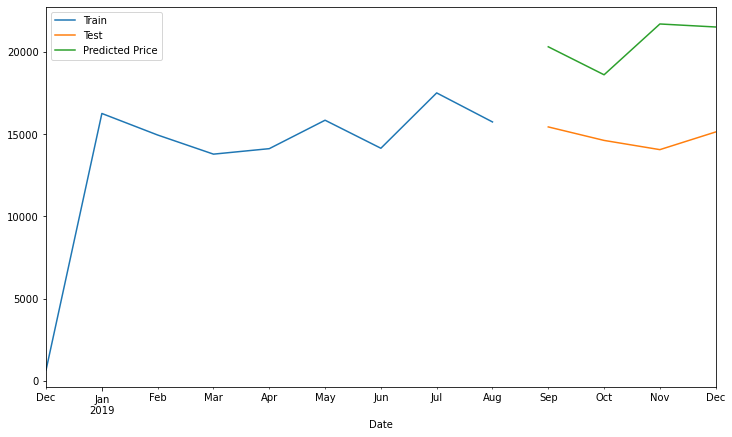

In [178]:
train["Price"].plot(legend = True, label = "Train", figsize = (12, 7))
test["Price"].plot(legend = True, label = "Test")
test_pred.plot(legend = True, label = "Predicted Price")

In [179]:
mape = np.mean(np.abs((test["Price"] - test_pred) / test["Price"])) * 100
mape

38.86386624905608

In [180]:
mae = mean_absolute_error(test["Price"], test_pred)
mae

5724.54549325808

In [181]:
mse = mean_squared_error(test["Price"], test_pred)
rmse = math.sqrt(mse)
rmse

5893.324211715957

### Final Model Built Based On Entire DataSet (Extra)

In [39]:
# final_model = ExponentialSmoothing(data["Price"], trend = "add", seasonal = "mul", seasonal_periods = 24).fit()

In [40]:
# pred = final_model.forecast(5)

In [41]:
# pred

In [42]:
# data["Price"].plot(legend = True, label = "Price", figsize = (12, 7))
# pred.plot(legend = True, label = "Predicted Price")